In [1]:
# Load packages
import os
import pandas as pd
import numpy as np
 # Required for basic python plotting functionality
import matplotlib.pyplot as plt
# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates
# Advanced plotting functionality with seaborn
import seaborn as sns

sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

In [2]:
productInfoDF = os.path.join(os.getcwd(), "./products_info.csv")
productInfoDF = pd.read_csv(productInfoDF)

In [3]:
productInfoDF["Primary Essential Function"].unique()

array(['LC - Digital Learning Platforms',
       'LC - Sites, Resources & Reference - Games & Simulations',
       'LC - Courseware & Textbooks', 'LC - Study Tools - Q&A',
       'LC - Sites, Resources & Reference - Streaming Services',
       'LC - Study Tools',
       'CM - Teacher Resources - Professional Learning',
       'SDO - Learning Management Systems (LMS)',
       'LC - Content Creation & Curation',
       'LC - Sites, Resources & Reference',
       'LC - Online Course Providers & Technical Skills Development',
       'CM - Classroom Engagement & Instruction - Communication & Messaging',
       'SDO - School Management Software - SSO',
       'LC - Sites, Resources & Reference - Thesaurus & Dictionary',
       'LC/CM/SDO - Other', 'SDO - Data, Analytics & Reporting',
       'LC - Sites, Resources & Reference - Encyclopedia',
       'CM - Classroom Engagement & Instruction - Classroom Management',
       'LC - Sites, Resources & Reference - Digital Collection & Repository',
 

In [4]:
engagmentListOfFiles = os.listdir("./engagement_data")
engagmentDict = {}
for csv in engagmentListOfFiles:
    engagmentDict[csv[:-4]] = pd.read_csv("./engagement_data/"+csv)

In [5]:
# Get data
districtDF = os.path.join(os.getcwd(), "./districts_info.csv")
districtDF = pd.read_csv(districtDF)

statesOfInterest = districtDF.state.unique()
print(statesOfInterest)
statesOfInterest = list (statesOfInterest)


['Illinois' nan 'Utah' 'Wisconsin' 'North Carolina' 'Missouri'
 'Washington' 'Connecticut' 'Massachusetts' 'New York' 'Indiana'
 'Virginia' 'Ohio' 'New Jersey' 'California' 'District Of Columbia'
 'Minnesota' 'Arizona' 'Texas' 'Tennessee' 'Florida' 'North Dakota'
 'New Hampshire' 'Michigan']


In [6]:
districtDF[districtDF['state'].isna()].isna().sum()

district_id                  0
state                       57
locale                      57
pct_black/hispanic          57
pct_free/reduced            57
county_connections_ratio    57
pp_total_raw                57
dtype: int64

From this we can tell that when the state value is equal to nan all other Nan collumn values are also nan except district_id . We should take a closer look at the engagment data for those districts

In [7]:
listofNanStates = list(districtDF[districtDF['state'].isna()].district_id)
for i in listofNanStates: 
    if i in engagmentDict:
        print(i)
# For the sake of memory i am going to delete the dictionary until i need it
del engagmentDict

This tells us that the district engagement data is not available for all of the rows where state="Nan". We will ommit this data as it has no value to us now and it will be impossible to find which district ID matches the state,locale etc... 

In [8]:
districtDF = districtDF[districtDF['state'].notna()]
statesOfInterest.remove(np.nan)
statesOfInterest= [str.upper(x) for x in statesOfInterest]

<h1> Exploring the Policy DataFrame</h1>

In [9]:
def preProcessingData():
    policyDataFrame = os.path.join(os.getcwd(), "./COVID-19 US state policy 3_29_2021.csv")
    policyDataFrame = pd.read_csv(policyDataFrame)
    originalStateColumn = policyDataFrame["STATE"]
    policyDataFrame = policyDataFrame.T
    dfs = [x for _, x in policyDataFrame.groupby(1)] # this allowed me to make 26 different series so i can take a look at each category carefully 
    listofDfs = []
    for miniDf in dfs: # This put the category description back 
        tempdf = miniDf.T
        tempdf["STATE"] = originalStateColumn
        listofDfs.append(tempdf)
    return listofDfs
    # for k in range (0, len(listofDfs)): # This allowed me to parse through each category dataframe to inspect it without having to save it onto my hard-drive giving me O(1) Space :) 
    #     temp = pd.DataFrame(listofDfs[k].iloc[0])
    #     print(listofDfs[k].T.reset_index()) 
def getMeDataFrame(k :int  , listofDfs : pd.DataFrame):
    temp = pd.DataFrame(listofDfs[k].iloc[0])
    return listofDfs[k].T.reset_index()
    # print(listofDfs[k].T.reset_index()) 


In [10]:
# Notes 
listofDfs = preProcessingData()
arbitraryNum = 22
getMeDataFrame(arbitraryNum,listofDfs) # This allowed me to parse through each category dataframe to inspect it without having to save it onto my hard-drive giving me O(1) Space :) 


,index,0,1,2,3,4,5,6,7,8,...,47,48,49,50,51,52,53,54,55,56
0,CLBAR3,Close Bars (x3),third_closures,start,date,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,CLRST3,Close Indoor Dining (x3),third_closures,start,date,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,END_CLRST3,Reopen Indoor Dining (x3),third_closures,end,date,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,STATE,State,category,type,unit,Alabama,Alaska,Arizona,Arkansas,California,...,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,NaN,NaN


This Preprossing of data allowed us to get these following categories of interest
- Reopening,food_security, masks,physical_distance_closure,physical_distance_closures,pre_covid_policy
- population_density,quarantines,reopening,second_closures,shelter,state_characteristics, State of emergency issued	

Along with These topics within each category : 
- Category [minimum_wage] = MINWAGEJAN2020	MINWAGEJUL2020	MINWAGESEP2020	MINWAGEOCT2020	TIPMINWAGE2020 (currently not focusing on this)
- Category [unemployment] = UIMAXDUR (currently not focusing on this)

<h1>End of pre-processing</h1>

In [11]:
policyDataFrame = os.path.join(os.getcwd(), "./COVID-19 US state policy 3_29_2021.csv")
policyDataFrame = pd.read_csv(policyDataFrame)
categoriesOfInterest = ["category","Reopening","food_security", "masks","physical_distance_closure","physical_distance_closures","pre_covid_policy"
"population_density","quarantines","reopening","second_closures","shelter,state_characteristics", "State of emergency issued"]

In [12]:
policyDataFrame= policyDataFrame.T[policyDataFrame.T[1].isin( categoriesOfInterest)].T
policyDataFrame= policyDataFrame.drop([55, 56])#.T # Drop the last two empty rows
policyDataFrame["STATE"] = policyDataFrame["STATE"].str.upper()

In [13]:
policyDataFrame.head()

,STATE,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,CLBSNS,CURFEW,END_BSNS,FM_ALL,FM_ALL2,...,SNAPALLO,SNAPEBT20,SNAPEBT21,SNAPSUSP,SNAPTLW,CASCLOSE,CASOPEN,CASCLOSE2,CASOPEN2,CASTRIBCAS
0,STATE,Date closed K-12 public schools,Closed day cares,Reopen day cares,Date banned visitors to nursing homes,Closed other non-essential businesses,Closed businesses overnight,Began to reopen businesses,Mandate face mask use by all individuals in pu...,Second mandate for facemasks by all individual...,...,SNAP Waiver - Emergency Allotments to Current ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Temporary Suspension of Claims C...,2020 Q1 SNAP ABAWD Time Limit Waiver,State-Mandated Casino Closure,State-Mandated Casino Re-Opening,Second Casino Closure,Second Casino Re-Opening,Mention of Tribal Casinos
1,CATEGORY,physical_distance_closure,physical_distance_closure,Reopening,physical_distance_closure,physical_distance_closure,physical_distance_closure,reopening,masks,masks,...,food_security,food_security,food_security,food_security,food_security,physical_distance_closures,reopening,second_closures,second_closures,physical_distance_closures
2,TYPE,start,start,end,start,start,start,end,start,start,...,start,start,start,start,attribute,start,end,start,end,attribute
3,UNIT,date,date,date,date,date,end,date,date,date,...,date,date,date,date,flag,date,date,date,date,flag
4,ALABAMA,20/3/2020,20/3/2020,23/5/2020,19/3/2020,28/3/2020,0,30/4/2020,16/7/2020,0,...,24/3/2020,4/21/2020,0,0,0,28/3/2020,22/5/2020,0,0,0


In [14]:
policyDataFrame['STATE'].unique()

array(['STATE', 'CATEGORY', 'TYPE', 'UNIT', 'ALABAMA', 'ALASKA',
       'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT',
       'DELAWARE', 'DISTRICT OF COLUMBIA', 'FLORIDA', 'GEORGIA', 'HAWAII',
       'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY',
       'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA',
       'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK',
       'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON',
       'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA',
       'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON',
       'WEST VIRGINIA', 'WISCONSIN', 'WYOMING'], dtype=object)

In [15]:
mask = policyDataFrame['STATE'].isin(statesOfInterest)
mask[0:4] = True # keep the first 4 headers 
policyDataFrame = policyDataFrame[mask].reset_index(drop=True)
policyDataFrame.head(10)

,STATE,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,CLBSNS,CURFEW,END_BSNS,FM_ALL,FM_ALL2,...,SNAPALLO,SNAPEBT20,SNAPEBT21,SNAPSUSP,SNAPTLW,CASCLOSE,CASOPEN,CASCLOSE2,CASOPEN2,CASTRIBCAS
0,STATE,Date closed K-12 public schools,Closed day cares,Reopen day cares,Date banned visitors to nursing homes,Closed other non-essential businesses,Closed businesses overnight,Began to reopen businesses,Mandate face mask use by all individuals in pu...,Second mandate for facemasks by all individual...,...,SNAP Waiver - Emergency Allotments to Current ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Temporary Suspension of Claims C...,2020 Q1 SNAP ABAWD Time Limit Waiver,State-Mandated Casino Closure,State-Mandated Casino Re-Opening,Second Casino Closure,Second Casino Re-Opening,Mention of Tribal Casinos
1,CATEGORY,physical_distance_closure,physical_distance_closure,Reopening,physical_distance_closure,physical_distance_closure,physical_distance_closure,reopening,masks,masks,...,food_security,food_security,food_security,food_security,food_security,physical_distance_closures,reopening,second_closures,second_closures,physical_distance_closures
2,TYPE,start,start,end,start,start,start,end,start,start,...,start,start,start,start,attribute,start,end,start,end,attribute
3,UNIT,date,date,date,date,date,end,date,date,date,...,date,date,date,date,flag,date,date,date,date,flag
4,ARIZONA,16/3/2020,0,0,0,31/3/2020,0,8/5/2020,0,0,...,1/4/2020,4/17/2020,2/25/2021,0,1,0,0,0,0,0
5,CALIFORNIA,23/3/2020,0,0,0,19/3/2020,11/21/2020,8/5/2020,18/6/2020,0,...,30/3/2020,4/23/2020,0,0,1,0,0,0,0,0
6,CONNECTICUT,17/3/2020,0,0,9/3/2020,23/3/2020,11/2/2020,20/5/2020,20/4/2020,0,...,28/3/2020,4/24/2020,0,2/4/2020,1,0,0,0,0,1
7,DISTRICT OF COLUMBIA,16/3/2020,0,0,0,25/3/2020,11/23/2020,29/5/2020,17/4/2020,0,...,1/4/2020,5/19/2020,3/22/2021,0,1,0,0,0,0,0
8,FLORIDA,17/3/2020,0,0,15/3/2020,3/4/2020,0,18/5/2020,0,0,...,30/3/2020,5/27/2020,3/1/2021,0,0,0,0,0,0,0
9,ILLINOIS,17/3/2020,23/3/2020,29/5/2020,0,21/3/2020,0,29/5/2020,1/5/2020,0,...,1/4/2020,4/17/2020,1/15/2021,0,1,16/3/2020,1/7/2020,20/11/2020,0,0


In [16]:
# Adding district_id column to csv files in engagement data folder

# Path to the engagement_data folder
folder_path = 'engagement_data'
df_list = []
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Extract the district ID from the filename
        district_id = filename.split('.')[0]

        # Add a new column to the dataframe with the district ID
        df['district_id'] = int(district_id)
        
        df_list.append(df)
engagement_data = pd.concat(df_list, ignore_index=True)
# Get rid of unnessary variables
del df_list
del df 



Upon further inspection of the 'Primary Essential Function' column, all nan values seem to be a part of a larger website url. Such as http://student.classdojo.com/#/login where class dojo is the primary website and login is just the login page. So we will be dropping those rows

In [17]:
productInfoDF.dropna(inplace=True)

In [18]:
mask = productInfoDF['Primary Essential Function'].str.startswith("LC")
productOfInterest = productInfoDF.loc[mask]
productOfInterest.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


In [19]:
engagement_data= engagement_data.dropna(subset=['lp_id'])

engagement_data['lp_id'] = engagement_data['lp_id'].astype(np.int64)

In [20]:
district_idDict= dict(zip(districtDF["district_id"],districtDF["state"]))
engagement_data['State'] = engagement_data['district_id'].map(district_idDict)

# We are dropping states rows that are Nan as they 
# are not a state of interest as previously described
engagement_data= engagement_data.dropna(subset=['State']).reset_index()
engagement_data['State'] = engagement_data['State'].apply(str.lower)



In [21]:
engagement_data['State'] = engagement_data['State'].apply(str.lower)


In [22]:
engagement_data.head()

,index,time,lp_id,pct_access,engagement_index,district_id,State
0,67430,2020-01-01,32213,0.41,18.49,7305,massachusetts
1,67431,2020-01-01,51340,0.07,6.85,7305,massachusetts
2,67432,2020-01-01,49062,0.07,6.16,7305,massachusetts
3,67433,2020-01-01,99916,0.41,10.27,7305,massachusetts
4,67434,2020-01-01,95731,0.68,47.26,7305,massachusetts


We will be focusing on when schools closed in 2020 (Label: CLSCHOOL) , when non-essential businesses closed/opened (Label: CLBSNS/END_BSNS), and when face mask manditaes where first instated(Label: FM_ALL). 

In [23]:
policiesOfInterestDF = (policyDataFrame[["STATE","CLSCHOOL","CLBSNS","END_BSNS","FM_ALL"]][4:]).copy()


In [24]:
policiesOfInterestDF['STATE'] = policiesOfInterestDF['STATE'].apply(str.lower)
for label in ["CLSCHOOL","CLBSNS","END_BSNS","FM_ALL"]:
    policiesOfInterestDF[label] = policiesOfInterestDF[label].apply(
        lambda x: (datetime.datetime.strptime(str(x), "%d/%m/%Y").date())
                if x != "0" else np.nan)


In [25]:
policiesOfInterestDF.head()

,STATE,CLSCHOOL,CLBSNS,END_BSNS,FM_ALL
4,arizona,2020-03-16,2020-03-31,2020-05-08,NaN
5,california,2020-03-23,2020-03-19,2020-05-08,2020-06-18
6,connecticut,2020-03-17,2020-03-23,2020-05-20,2020-04-20
7,district of columbia,2020-03-16,2020-03-25,2020-05-29,2020-04-17
8,florida,2020-03-17,2020-04-03,2020-05-18,NaN


In [26]:
policiesOfInterestDF.head()

,STATE,CLSCHOOL,CLBSNS,END_BSNS,FM_ALL
4,arizona,2020-03-16,2020-03-31,2020-05-08,NaN
5,california,2020-03-23,2020-03-19,2020-05-08,2020-06-18
6,connecticut,2020-03-17,2020-03-23,2020-05-20,2020-04-20
7,district of columbia,2020-03-16,2020-03-25,2020-05-29,2020-04-17
8,florida,2020-03-17,2020-04-03,2020-05-18,NaN


In [27]:
temp = pd.merge(engagement_data, policiesOfInterestDF, left_on='State', right_on='STATE')
finaldf = pd.merge(temp, productOfInterest, left_on='lp_id', right_on='LP ID')
del temp
del engagement_data

In [28]:
finaldf= finaldf.drop(["index","STATE","LP ID"], axis=1)
finaldf.rename(columns = {'time':'EngagementDateRecorded'}, inplace = True)

In [29]:
# Convert to date-time
finaldf["EngagementDateRecorded"] = finaldf["EngagementDateRecorded"].apply(
        lambda x: (datetime.datetime.strptime(str(x), "%Y-%m-%d").date())
)
 # certain rows have percentages over 1, i belive this is because certain ' lp_id''s reported percentages as a full number
#  for example 99% instead of 0.99 so we will convert it into a common base
finaldf["pct_access"] = finaldf["pct_access"].apply( lambda x: x/100 if x >1 else x) 
finaldf.head()

,EngagementDateRecorded,lp_id,pct_access,engagement_index,district_id,State,CLSCHOOL,CLBSNS,END_BSNS,FM_ALL,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,2020-01-01,51340,0.0700,6.85,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
1,2020-01-02,51340,0.0103,22.60,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
2,2020-01-03,51340,0.0205,82.88,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
3,2020-01-04,51340,0.1400,30.82,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
4,2020-01-06,51340,0.0253,79.45,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools


In [30]:
x = finaldf.sample(frac=0.3, random_state=1)
del finaldf

Reminder: 
- CLSCHOOL corresponds to :  Date closed K-12 public schools	
- CLBSNS corresponds to :  Closed other non-essential businesses	
- END_BSNS corresponds to :  Began to reopen businesses	
- FM_ALL corresponds to : Mandate face mask use by all individuals in public spaces

In [31]:
# using this we can see what dates certain policies happened 
display(x["CLSCHOOL"].value_counts())
display(x["CLBSNS"].value_counts())
display(x["END_BSNS"].value_counts())
display(x["FM_ALL"].value_counts())

2020-03-17    1183887
2020-03-16     515519
2020-03-23     275176
2020-03-18     106141
2020-03-20     105208
2020-03-21      18232
Name: CLSCHOOL, dtype: int64

2020-03-24    452052
2020-03-23    366103
2020-03-27    312412
2020-03-21    308894
2020-03-25    299357
2020-03-19    160417
2020-04-03    138551
2020-03-30     57470
2020-03-22     46805
2020-04-01     20176
2020-03-28     18615
2020-04-02     18232
2020-03-31      4779
2020-03-20       300
Name: CLBSNS, dtype: int64

2020-05-18    413868
2020-05-29    381143
2020-05-20    366103
2020-05-01    330944
2020-05-04    262185
2020-05-08    222666
2020-06-01     86932
2020-06-08     46805
2020-05-11     42415
2020-05-26     26734
2020-04-27     24368
Name: END_BSNS, dtype: int64

2020-04-20    366103
2020-04-10    312412
2020-05-01    281742
2020-05-06    277892
2020-06-18    160417
2020-07-23    147426
2020-06-26    144402
2020-07-27     85032
2020-05-29     75504
2020-04-17     70702
2020-08-01     27992
2020-04-08     27152
2020-04-27     26734
2020-07-03     18232
2020-11-20     14423
2020-07-24      4192
2020-11-14       300
Name: FM_ALL, dtype: int64

Recall That 
- we can see that most schools and non-essential busniess closed around the end of march for most states of interest 
- we can also conclude that most states reopened busniess mid May
- For facemasks its hard 'average' out what time of year face masks were fazed out. So we belive that it will be unfair to give an exact date

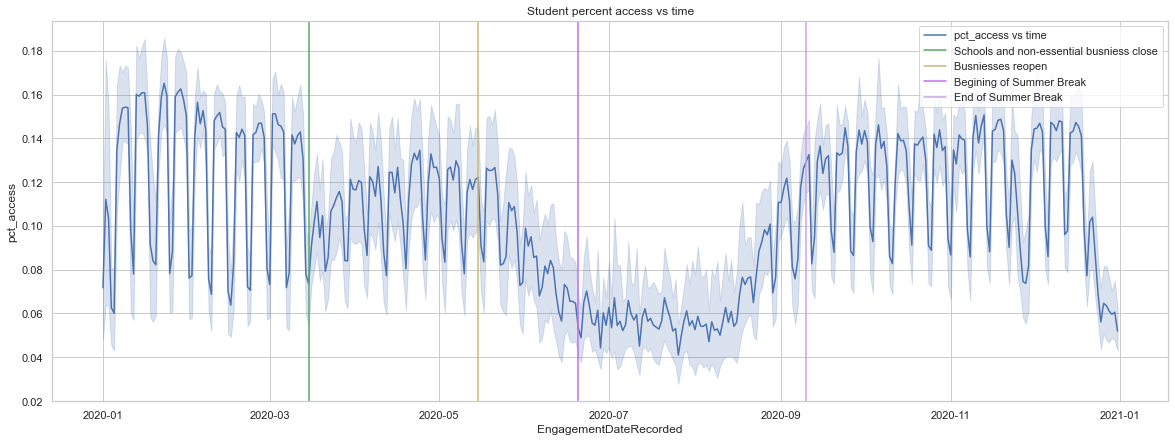

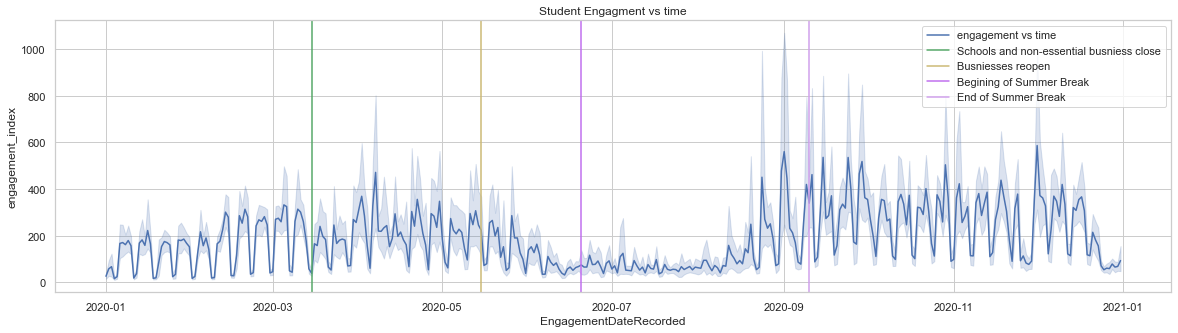

In [32]:
 # CLSCHOOL	CLBSNS	END_BSNS	FM_ALL	
# 2020-03-17	2020-03-24	2020-05-18	2020-05-06
temp = x.groupby(["EngagementDateRecorded","State"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(data=temp, x="EngagementDateRecorded", y="pct_access",label="pct_access vs time")
ax.set_title("Student percent access vs time")
plt.axvline(datetime.datetime(2020, 3, 15),color='g',label="Schools and non-essential busniess close") # Date when schools and busnisess closed (on avg) 
plt.axvline(datetime.datetime(2020, 5, 15),color='y', label= "Busniesses reopen") # Date when busnisess reopened (on avg) 
plt.axvline(datetime.datetime(2020, 6, 20),color='#C06EEF',label="Begining of Summer Break") # Date when schools close for due to summer break 
plt.axvline(datetime.datetime(2020, 9, 10),color='#D0A0EC', label= "End of Summer Break") # summer break ends 
ax.legend()


fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=temp, x="EngagementDateRecorded", y="engagement_index",label="engagement vs time")
ax.set_title("Student Engagment vs time")
plt.axvline(datetime.datetime(2020, 3, 15),color='g',label="Schools and non-essential busniess close") # Date when schools and busnisess closed (on avg) 
plt.axvline(datetime.datetime(2020, 5, 15),color='y', label= "Busniesses reopen") # Date when busnisess reopened (on avg) 
plt.axvline(datetime.datetime(2020, 6, 20),color='#C06EEF',label="Begining of Summer Break") # Date when schools close for due to summer break 
plt.axvline(datetime.datetime(2020, 9, 10),color='#D0A0EC', label= "End of Summer Break") # summer break ends 

ax.legend()



- We can clearly see in the first graph of percent access vs Time, that when schools and busniess closed we had an increase of students from pre k- grade 12 accessing more online content
- Then when non-essential busniess reopened it seems that students had a decrease in overall percent access, HOWEVER upon further investigation we have realized that the decrease is most likely a result of schools being closed for summer break  
- The engagement data for the given platforms seems to be very lineary meaning that regardless of policy change on average students engaged with websites the same as before a policy change.
- That being said there may be some policies or other factors that we are not looking that may effect the engagement data. This will require weeks more of research and is outside the scope of this project

- We are currently looking at an average of the engagement data for over 200 different providers throughout 2020
- Lets now look at the most 'popular' providers engagement data differed throughout policy changes. 

In [55]:
# Dataframe for the period between jan 1st - When schools closed - when summer break happened
effectsofPolicyChange = list()

beforePolicyChange = (x.loc[x['EngagementDateRecorded'] < x["CLSCHOOL"]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
afterPolicyChange  = (x.loc[x['CLSCHOOL'] < datetime.date(2020, 6, 20)]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()

tempdf = pd.merge(beforePolicyChange,afterPolicyChange, on =['State','Provider/Company Name'])

tempdf.rename(columns = {'pct_access_x':'pct_access_before','engagement_index_x':'engagement_index_before',
                                'pct_access_y':'pct_access_after','engagement_index_y':'engagement_index_after'}, inplace = True)
tempdf = tempdf.dropna(axis=0)
tempdf["engagementDifference"] = tempdf["engagement_index_after"] -  tempdf["engagement_index_before"]
tempdf["pct_access_Difference"] = tempdf["pct_access_after"] - tempdf["pct_access_before"]     
tempdf.name = "CLSCHOOL"
effectsofPolicyChange.append(tempdf)


In [56]:
# Dataframe describing the period between when schools reopened in september vs how they were when they first closed in march - june 
beforePolicyChange  = (x.loc[x['CLSCHOOL'] < datetime.date(2020, 6, 20)]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
afterPolicyChange  = (x.loc[x['EngagementDateRecorded']  > datetime.date(2020, 9, 10)]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()

tempdf = pd.merge(beforePolicyChange,afterPolicyChange, on =['State','Provider/Company Name'])

tempdf.rename(columns = {'pct_access_x':'pct_access_before','engagement_index_x':'engagement_index_before',
                                'pct_access_y':'pct_access_after','engagement_index_y':'engagement_index_after'}, inplace = True)
tempdf = tempdf.dropna(axis=0)
tempdf["engagementDifference"] = tempdf["engagement_index_after"] -  tempdf["engagement_index_before"]
tempdf["pct_access_Difference"] = tempdf["pct_access_after"] - tempdf["pct_access_before"]     
tempdf.name = "SchoolsReopened"
effectsofPolicyChange.append(tempdf)



In [57]:
# This one is slightly different because you want the interval between when busniessed closed and reopened 
beforePolicyChange = (x.loc[x['EngagementDateRecorded'] < x["CLBSNS"]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index() # Key difference here
afterPolicyChange = (x.loc[x['CLBSNS'] < x["END_BSNS"]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index() # Key difference here
tempdf = pd.merge(beforePolicyChange,afterPolicyChange, on =['State','Provider/Company Name'])
tempdf.rename(columns = {'pct_access_x':'pct_access_before','engagement_index_x':'engagement_index_before',
                                'pct_access_y':'pct_access_after','engagement_index_y':'engagement_index_after'}, inplace = True)
tempdf = tempdf.dropna(axis=0)
tempdf["engagementDifference"] = tempdf["engagement_index_after"] -  tempdf["engagement_index_before"]
tempdf["pct_access_Difference"] = tempdf["pct_access_after"] - tempdf["pct_access_before"]     
tempdf.name = "CLBSNS"
effectsofPolicyChange.append(tempdf)



beforePolicyChange = (x.loc[x['CLBSNS'] < x["END_BSNS"]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
afterPolicyChange = (x.loc[x['END_BSNS'] > x["EngagementDateRecorded"]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
tempdf = pd.merge(beforePolicyChange,afterPolicyChange, on =['State','Provider/Company Name'])
tempdf.rename(columns = {'pct_access_x':'pct_access_before','engagement_index_x':'engagement_index_before',
                                'pct_access_y':'pct_access_after','engagement_index_y':'engagement_index_after'}, inplace = True)
tempdf = tempdf.dropna(axis=0)
tempdf["engagementDifference"] = tempdf["engagement_index_after"] -  tempdf["engagement_index_before"]
tempdf["pct_access_Difference"] = tempdf["pct_access_after"] - tempdf["pct_access_before"]     
tempdf.name = "END_BSNS"
effectsofPolicyChange.append(tempdf)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Label name: CLSCHOOL
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference    -18.028338
pct_access_Difference    -0.016186
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.122733,99.294099,0.108084,78.524031,-20.770068,-0.014648
std,0.053348,39.452364,0.058150,36.739456,15.696112,0.010022
min,0.070074,46.054507,0.053889,34.145782,-61.098485,-0.034820
25%,0.090791,65.079301,0.073528,52.539499,-26.570928,-0.021023
50%,0.115215,92.269185,0.104730,73.684647,-18.028338,-0.016186
75%,0.125727,120.207674,0.111384,95.992604,-9.010663,-0.008451
max,0.334145,189.116676,0.334145,189.116676,0.000000,0.007637


Text(0.5, 1.0, 'Engagement Difference before the first school lock down')

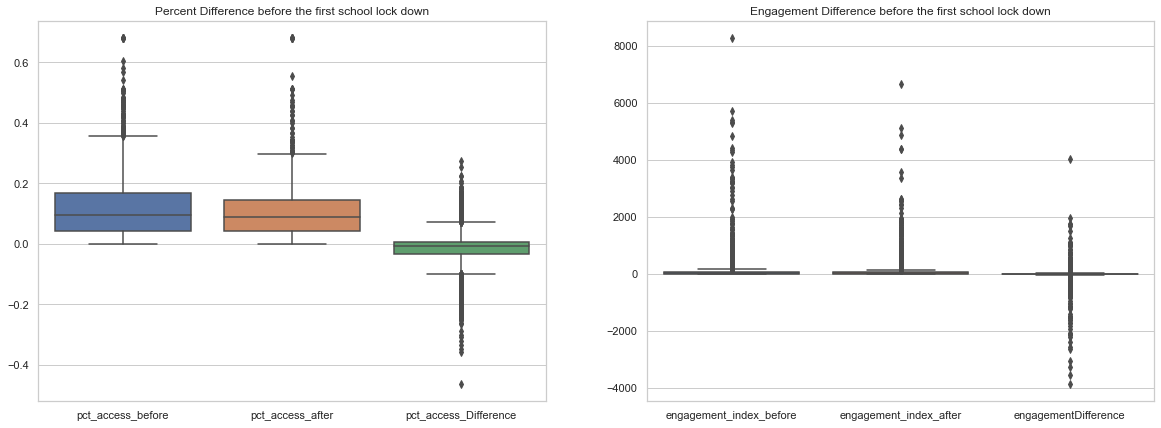

In [133]:
df = effectsofPolicyChange[0]
print("Label name: " + df.name)
print("Median of the average engagement/percent-access  differences for each state:")
print("------------------------------------")
print(df.groupby("State")[["engagementDifference","pct_access_Difference"]].mean().median())
print("------------------------------------")
display(df.groupby("State").mean().reset_index().describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.boxplot(data=df[["pct_access_before","pct_access_after","pct_access_Difference"]],ax=ax[0])
ax[0].set_title('Percent Difference before the first school lock down')

sns.boxplot(data=df[["engagement_index_before","engagement_index_after","engagementDifference"]],ax=ax[1])
ax[1].set_title('Engagement Difference before the first school lock down')

Label name: SchoolsReopened
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference     7.140975
pct_access_Difference    0.006820
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.096775,71.956963,0.104180,79.168681,7.211718,0.007405
std,0.032312,29.679787,0.029177,27.206613,14.152639,0.009279
min,0.055135,31.924829,0.070331,36.431015,-25.479348,-0.021424
25%,0.070756,51.803376,0.077880,57.717341,3.937164,0.004359
50%,0.098437,75.176150,0.100552,84.724216,7.140975,0.006820
75%,0.109503,85.984107,0.117142,101.919045,13.864856,0.013053
max,0.164845,136.168147,0.168619,128.065049,37.643277,0.022371


Text(0.5, 1.0, 'Engagement Difference before the first school lock down')

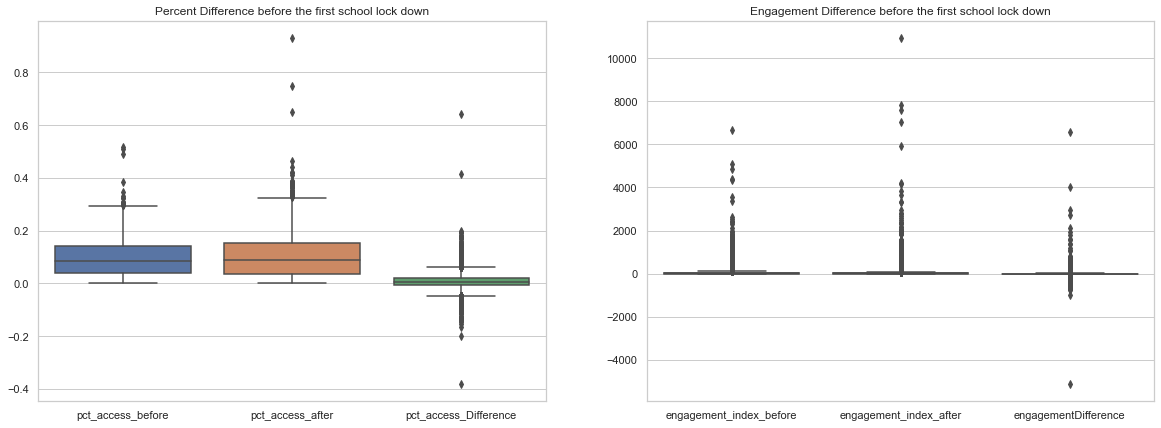

In [134]:
df = effectsofPolicyChange[1]
print("Label name: " + df.name)
print("Median of the average engagement/percent-access  differences for each state:")
print("------------------------------------")
print(df.groupby("State")[["engagementDifference","pct_access_Difference"]].mean().median())
print("------------------------------------")
display(df.groupby("State").mean().reset_index().describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.boxplot(data=df[["pct_access_before","pct_access_after","pct_access_Difference"]],ax=ax[0])
ax[0].set_title('Percent Difference before the first school lock down')

sns.boxplot(data=df[["engagement_index_before","engagement_index_after","engagementDifference"]],ax=ax[1])
ax[1].set_title('Engagement Difference before the first school lock down')

Label name: CLBSNS
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference    -16.755708
pct_access_Difference    -0.012495
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.119701,96.129518,0.107687,78.031157,-18.098361,-0.012014
std,0.054615,40.060228,0.058071,36.764844,15.639198,0.008993
min,0.063888,43.274121,0.053409,34.145782,-54.877033,-0.029774
25%,0.090078,60.882465,0.073528,52.418127,-26.866613,-0.017852
50%,0.112895,92.326576,0.104730,73.684647,-16.755708,-0.012495
75%,0.124019,113.864035,0.111384,95.931016,-5.789942,-0.005806
max,0.334145,189.116676,0.334145,189.116676,7.079988,0.006126


Text(0.5, 1.0, 'Engagement Difference before the first school lock down')

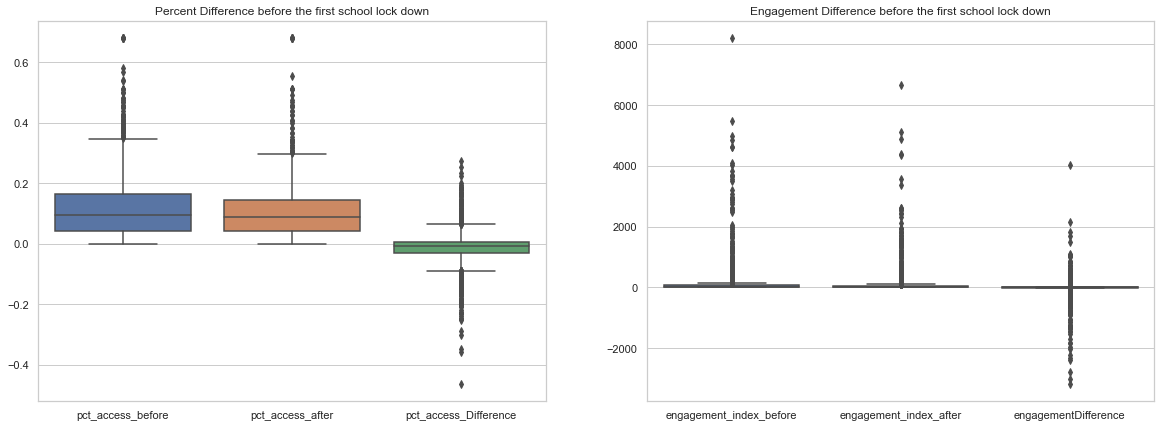

In [135]:
df = effectsofPolicyChange[2]
print("Label name: " + df.name)
print("Median of the average engagement/percent-access  differences for each state:")
print("------------------------------------")
print(df.groupby("State")[["engagementDifference","pct_access_Difference"]].mean().median())
print("------------------------------------")
display(df.groupby("State").mean().reset_index().describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.boxplot(data=df[["pct_access_before","pct_access_after","pct_access_Difference"]],ax=ax[0])
ax[0].set_title('Percent Difference before the first school lock down')

sns.boxplot(data=df[["engagement_index_before","engagement_index_after","engagementDifference"]],ax=ax[1])
ax[1].set_title('Engagement Difference before the first school lock down')

Label name: END_BSNS
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference     5.671076
pct_access_Difference    0.009172
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.105961,74.737770,0.114100,81.829377,7.091607,0.008139
std,0.058104,35.660545,0.057819,37.809907,11.794522,0.008519
min,0.052763,34.145782,0.053942,34.932258,-17.395826,-0.012772
25%,0.071927,50.327248,0.082161,52.867730,0.003867,0.002919
50%,0.102222,70.614452,0.108949,75.563004,5.671076,0.009172
75%,0.109271,91.973172,0.120617,100.314566,16.597215,0.012019
max,0.334145,189.116676,0.334145,189.116676,28.025620,0.026260


Text(0.5, 1.0, 'Engagement Difference before the first school lock down')

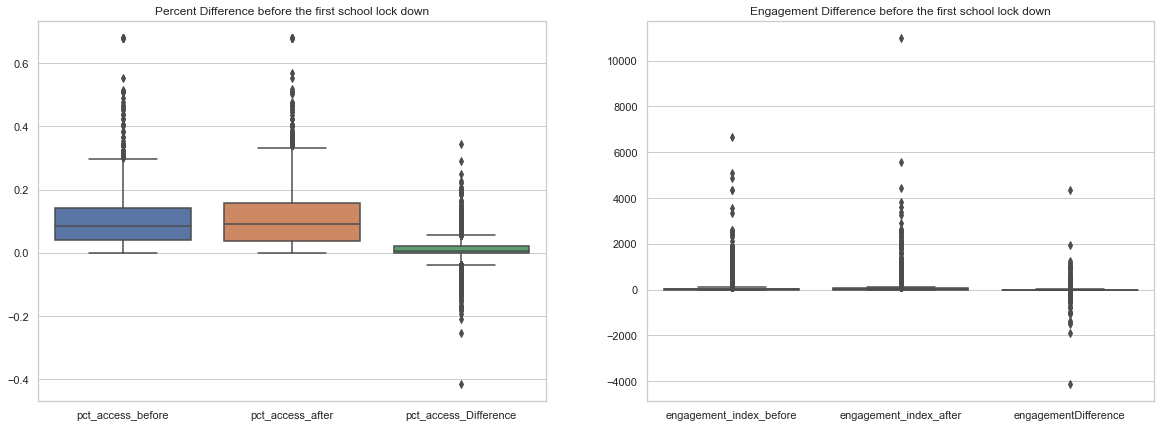

In [137]:
df = effectsofPolicyChange[3]
print("Label name: " + df.name)
print("Median of the average engagement/percent-access  differences for each state:")
print("------------------------------------")
print(df.groupby("State")[["engagementDifference","pct_access_Difference"]].mean().median())
print("------------------------------------")
display(df.groupby("State").mean().reset_index().describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.boxplot(data=df[["pct_access_before","pct_access_after","pct_access_Difference"]],ax=ax[0])
ax[0].set_title('Percent Difference before the first school lock down')

sns.boxplot(data=df[["engagement_index_before","engagement_index_after","engagementDifference"]],ax=ax[1])
ax[1].set_title('Engagement Difference before the first school lock down')

### ---------------------------------------BREAK---------------------------------------

In [70]:
meanEngagmentBefore = df["engagement_index_before"].mean()
meanEngagmentAfter = df["engagement_index_after"].mean()

pctAcessBefore = df["pct_access_before"].mean()
pctAcessAfter = df["pct_access_after"].mean()

It seems that on average most websites decreased the amount of visits and engagement after schools were closed and busniess closed.
However when busniess reopened and more students enageged and visited a larger variety of websites.

This seems to be going away from our original ituttion. Students should tend to be more online when not in school . 
Instead of looking at all learning platforms lets take a look at the ones with the most student engagement. Ie the most 'popular' 

Lets find the top 10 most popular platforms 'before' the pandemic ie, before schools and busniesses closed in mid march 

In [138]:
before_the_first_majorPolicy = effectsofPolicyChange[0]
print(before_the_first_majorPolicy.name)
display(before_the_first_majorPolicy)

CLSCHOOL


,State,Provider/Company Name,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
0,arizona,"Autodesk, Inc",0.251800,15.430000,0.167867,15.430000,0.000000,-0.083933
1,arizona,Tes Global Ltd,0.120000,2.470000,0.120000,2.470000,0.000000,0.000000
3,arizona,"ABCya.com, LLC",0.179333,25.086667,0.172683,26.857179,1.770513,-0.006650
4,arizona,Actively Learn,0.120000,4.930000,0.276481,85.902703,80.972703,0.156481
5,arizona,Adobe Inc.,0.102170,33.003750,0.115394,18.690667,-14.313083,0.013224
...,...,...,...,...,...,...,...,...
4477,wisconsin,iCivics Inc,0.240108,97.122432,0.171396,53.351333,-43.771099,-0.068712
4478,wisconsin,iHeartRadio,0.246923,88.182727,0.096492,40.981406,-47.201321,-0.150431
4479,wisconsin,iStockphoto LP,0.052941,1.260625,0.035208,1.311944,0.051319,-0.017733
4480,wisconsin,mrdonn.org,0.166316,7.995294,0.100500,6.142903,-1.852391,-0.065816


In [139]:
top10pctAccess= list(before_the_first_majorPolicy.groupby(["Provider/Company Name"])["pct_access_before"].mean().reset_index().sort_values(by="pct_access_before", ascending = False).head(10)["Provider/Company Name"])
top10engagment= list(before_the_first_majorPolicy.groupby(["Provider/Company Name"])["engagement_index_before"].mean().reset_index().sort_values(by="engagement_index_before",ascending = False).head(10)["Provider/Company Name"])
# topPlatforms = list(set(top10pctAccess+top10engagment))

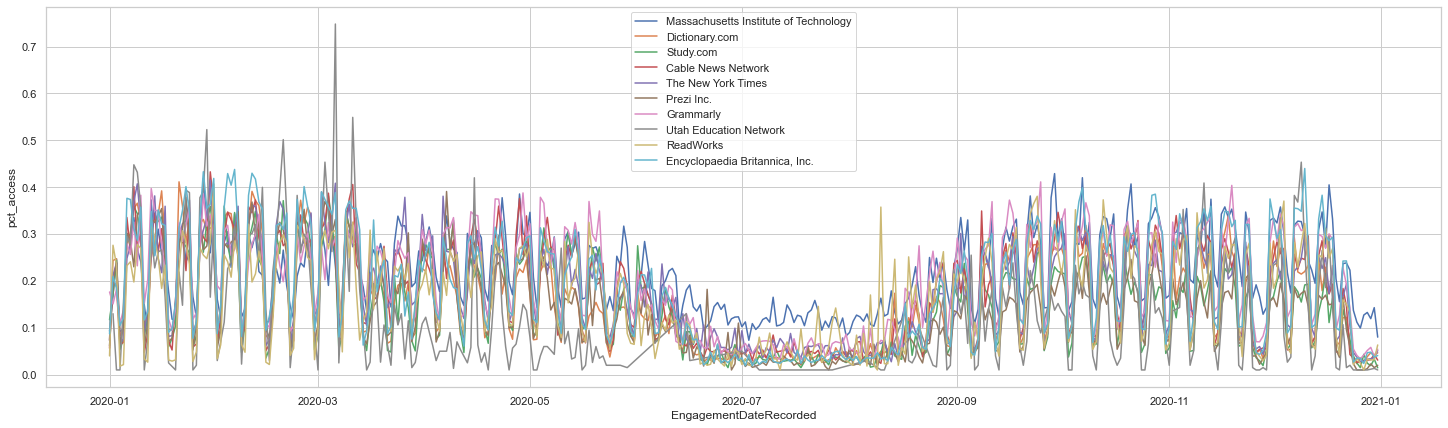

In [140]:
temp = x[x['Provider/Company Name'].isin(top10pctAccess)][["EngagementDateRecorded","pct_access","Provider/Company Name"]]

# After looking at the data i have realzied that many of the dates have a pct_access that is equal to zero , i believe that the data is missing. Therefor i will remove the 'zero' rows
temp = temp.loc[temp['pct_access'] != 0] 
temp['EngagementDateRecorded'] = pd.to_datetime(temp['EngagementDateRecorded'])

temp['month'] = temp['EngagementDateRecorded'].dt.month

fig, ax = plt.subplots(figsize=(25, 7))
sns.lineplot(data =temp, y= 'pct_access', x = 'EngagementDateRecorded', hue = 'Provider/Company Name', errorbar = None)
# plt.axvline(x=3,color='#515C54',lw = '4',label="Schools and non-essential busniess close") # Date when schools and busnisess closed (on avg) 
# plt.axvline(x=5,color='#648679',lw = '4', label= "Busniesses reopen") # Date when busnisess reopened (on avg) 

ax.legend()
# # ax.set_title(str(airPollutant)+" Emissions vs Year ")

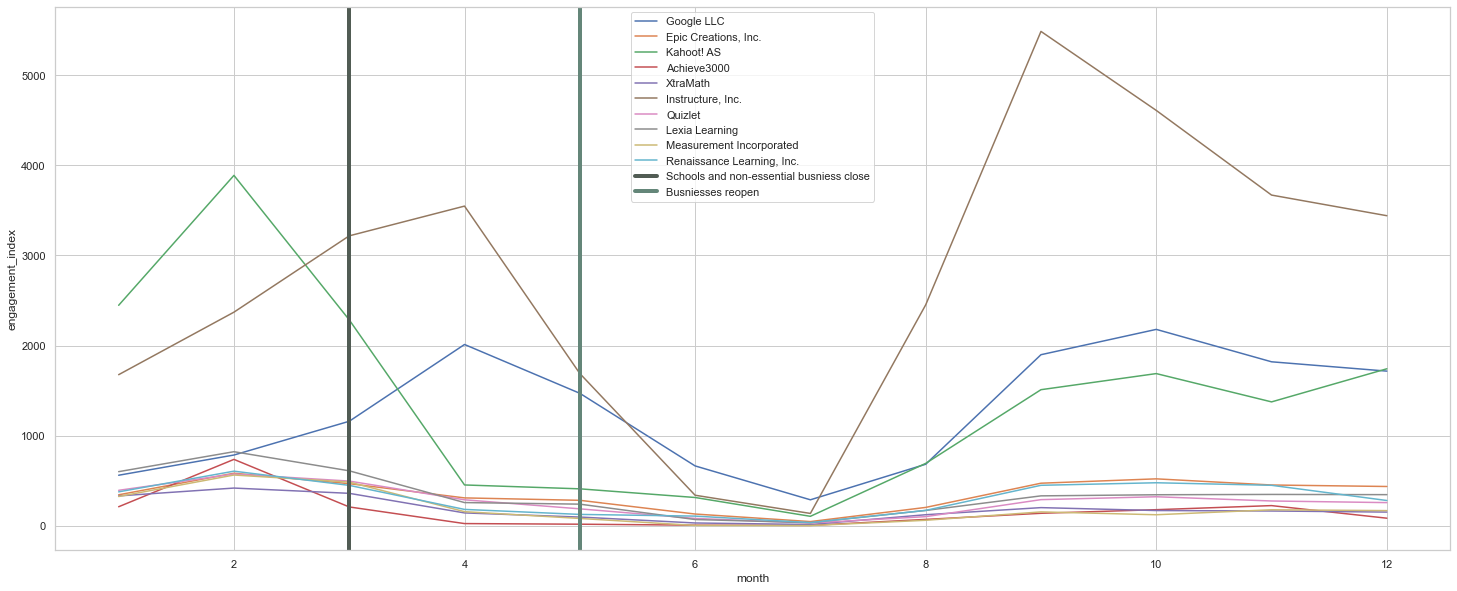

In [141]:
temp = x[x['Provider/Company Name'].isin(top10engagment)][["EngagementDateRecorded","engagement_index","Provider/Company Name"]]
# After looking at the data i have realzied that many of the dates have a engagement_index that is equal to ze or nan ro , i believe that the data is missing. Therefor i will remove the 'zero' rows
temp = temp.loc[temp['engagement_index'] != 0] 
temp['EngagementDateRecorded'] = pd.to_datetime(temp['EngagementDateRecorded'])

temp['month'] = temp['EngagementDateRecorded'].dt.month

fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(data =temp, y= 'engagement_index', x = 'month', hue = 'Provider/Company Name', errorbar = None)
plt.axvline(x=3,color='#515C54',lw = '4',label="Schools and non-essential busniess close") # Date when schools and busnisess closed (on avg) 
plt.axvline(x=5,color='#648679',lw = '4', label= "Busniesses reopen") # Date when busnisess reopened (on avg) 

ax.legend()
# # ax.set_title(str(airPollutant)+" Emissions vs Year ")

In [142]:
df_list = []

topProviderandCompanies = pd.DataFrame()
for df in effectsofPolicyChange:
    # print("Label name: " + df.name)
    # print("Median of the average engagement/percent-access  differences for each state:")
    # print("------------------------------------")
    temp = df.groupby("Provider/Company Name")[["engagementDifference","pct_access_Difference"]].mean()

    df_list.append(temp.nlargest(10, 'engagementDifference'))
    df_list.append(temp.nlargest(10, 'pct_access_Difference'))

    # print(df.groupby("Provider/Company Name")[["engagementDifference","pct_access_Difference"]].mean())
    # print("------------------------------------")
    # display(df.groupby("Provider/Company Name").mean().reset_index().describe())


temp1234 = pd.concat(df_list, ignore_index=False)


In [62]:
# temp.nlargest(10, 'pct_access_Difference')


In [143]:
temp1234.sort_values(by="engagementDifference",ascending=False).head(20)

,engagementDifference,pct_access_Difference
Provider/Company Name,,
"Instructure, Inc.",826.398139,0.023767
Google LLC,572.333838,-0.018342
Seesaw Learning Inc,563.315253,0.105922
Seesaw Learning Inc,563.315253,0.105922
Kahoot! AS,560.740589,0.013142
Google LLC,554.558554,0.011935
Google LLC,545.393176,-0.015370
Seesaw Learning Inc,452.524913,0.075242
Seesaw Learning Inc,452.524913,0.075242


In [37]:
workingDf.groupby("Provider/Company Name").mean()

Since there is alot of different websites we will only take a 

## ------------------------- BREAK ------------------------------